# Hinge Torques Monitoring

![Geometry overview](../thumbnails/aileron_rudder_airplane_geometry.png)

This tutorial will show how to set up a case where moments on specific surfaces are monitored throughout the simulation. The content will cover:
- creating a project from a geometry,
- meshing using the beta mesher and automated farfield,
- setup of a steady case,
- setup of `SurfaceIntegralOutput` using `UserVariable` to capture hinge moments on control surfaces,
- results postprocessing.

## 1. Imports and Project Creation

To begin working with the **Flow360** API it is necessary to firstly import the `flow360` python package that will be the interface between you and the software. The files necessary for this example are being downloaded through the `TutorialUDDForcesMoments` example. 

All simulations are managed through the `Project` object, which stores all the runs associated with a certain root asset. Root asset can be a geometry, surface mesh or volume mesh. In case of this tutorial the `Project` will be started from the geometry.

In [1]:
import flow360 as fl
from flow360.examples import TutorialUDDForcesMoments

In [2]:
TutorialUDDForcesMoments.get_files()

project = fl.Project.from_geometry(
    TutorialUDDForcesMoments.geometry, name="Monitoring hinge torques"
)

Output()

[10:16:16] INFO: Geometry successfully submitted:                                                                  
                   type        = Geometry                                                                          
                   name        = Monitoring hinge torques                                                          
                   id          = geo-ca5ad8b9-6320-4438-ba13-9b22704743f3                                          
                   status      = uploaded                                                                          
                   project id  = prj-c1642540-6862-4460-89f3-220e400aa909                                          
           

           INFO: Waiting for geometry to be processed.

Output()

If the `Project` has already been created before it is possible to retrieve it using its unique ID.

In [3]:
# project=fl.Project.from_cloud("prj-e8aa4e7a-a6b8-47f5-97c4-7e64bbf76aeb")

`Project` contains all the information about its root asset, in this case - geometry. To be able to correctly reference it it is necessary to group the faces and edges by the attribute that was assigned to distinguish the faces in a CAD file. 

In [4]:
geometry = project.geometry

geometry.group_edges_by_tag("edgeName")
geometry.group_faces_by_tag("groupName")

print("Geometry boundaries:")
for boundary in geometry.entity_info.get_boundaries():
    print(f"- {boundary.name}")

[10:17:08] INFO: Regrouping face entities under `groupName` tag (previous `faceName`).

Geometry boundaries:
- vTailLeft
- fuselage
- wingLeft
- wingRight
- vTailRight
- rudderLeft
- rudderRight
- aileronLeft
- aileronRight


## 2. Meshing
When the projects starts from the geometry it is necessary to set up the automated meshing workflow.

Firstly the AutomatedFarfield object is created to indicate that the geometry only contains the simulated object and the farfield has to be created around it.

Then the defaults for meshing are defined. Those are the "global" settings for the mesher.

In [5]:
farfield = fl.AutomatedFarfield()

with fl.SI_unit_system:
    meshing = fl.MeshingParams(
        defaults=fl.MeshingDefaults(
            surface_max_edge_length=0.5,
            curvature_resolution_angle=10 * fl.u.deg,
            boundary_layer_first_layer_thickness=2e-6,
            boundary_layer_growth_rate=1.2,
        ),
        volume_zones=[farfield],
    )

[10:17:15] INFO: using: SI unit system for unit inference.

To refine specific parts of the mesh the `refinements` field is used, where user can define surface (such as `SurfaceRefinement` and `SurfaceEdgeRefinement`) and volumetric refinements (`UniformRefinement`).

It is worth to notice how the specific parts of the geometry are referenced using the `geometry` object. They can be then referenced using face names directly or through a wildcard entry (`*`). 

In [6]:
with fl.SI_unit_system:
    box1 = fl.Box(
        name="box1", size=[2, 6, 3], center=[6.5, 9, 0], axis_of_rotation=[0, 1, 0]
    )
    box2 = fl.Box(
        name="box2", size=[2, 6, 3], center=[6.5, -9, 0], axis_of_rotation=[0, 1, 0]
    )
    box3 = fl.Box(
        name="box3", size=[4, 8, 3], center=[12, 0, 2], axis_of_rotation=[0, 1, 0]
    )

    meshing.refinements.extend(
        [
            fl.SurfaceEdgeRefinement(
                method=fl.AngleBasedRefinement(value=1 * fl.u.deg),
                edges=[geometry["leadingEdge"]],
            ),
            fl.SurfaceEdgeRefinement(
                method=fl.HeightBasedRefinement(value=5e-3),
                edges=[geometry["trailingEdge"]],
            ),
            fl.SurfaceRefinement(max_edge_length=0.5, faces=[geometry["wing*"]]),
            fl.UniformRefinement(
                name="box_refinement1", entities=[box1, box2, box3], spacing=0.2
            ),
        ]
    )

[10:17:18] INFO: using: SI unit system for unit inference.

## 3. Boundary Conditions, Flow physics and numerics settings

To describe the physical behaviour of the flow the Boundary Conditions or surface models are used. In this case the ones needed would be the `Freestream` condition that is assigned to the farfield and the `Wall` condition for the object. The `Fluid` model is a volume model that enables access to the controls of the fluid solver.

The `operating_condition` is responsible for defining the fluid behaviour at the freestream and is used to set the velocity, angle of attack and the thermal state of the fluid in this case.

`reference_geometry` defines values that are used as a reference when calculating various coefficients. 

Finally `time_stepping` describes whether the simulation is steady or transient and how many time (or pseudo time) steps should be performed.

In [7]:
with fl.SI_unit_system:
    reference_geometry = fl.ReferenceGeometry(
        area=60, moment_center=[5.7542, 0, 0], moment_length=[1, 1, 1]
    )
    operating_condition = fl.AerospaceCondition(
        velocity_magnitude=50,
        alpha=10 * fl.u.deg,
        atmosphere=fl.ThermalState(temperature=288.15),
    )
    models = [
        fl.Fluid(
            navier_stokes_solver=fl.NavierStokesSolver(
                absolute_tolerance=1e-9,
                linear_solver=fl.LinearSolver(max_iterations=35),
            ),
            turbulence_model_solver=fl.SpalartAllmaras(
                linear_solver=fl.LinearSolver(max_iterations=25)
            ),
        ),
        fl.Wall(
            surfaces=[geometry["*Left"], geometry["*Right"], geometry["fuselage"]],
        ),
        fl.Freestream(surfaces=[farfield.farfield]),
    ]
    time_stepping = fl.Steady(max_steps=5000)

[10:17:20] INFO: using: SI unit system for unit inference.

## 4. Definition of `UserVariable`s

In the next cell, we define several custom `UserVariable`s to compute hinge torques for the control surfaces (right/left ailerons and right/left rudders). 
Each variable calculates the local contribution to the hinge torque by taking the moment (cross product) of the force per unit area about a specified torque center, and then projecting that moment onto the relevant hinge axis. The resulting user variables represent the hinge torque per unit area at each surface node, 
with units of pressure times length (Pa·m), and can be integrated over the relevant surfaces to obtain the total hinge torque values.

>Note: The variables are defined **per unit area** because `SurfaceIntegralOutput` integrates over the surface area, not over individual nodes.

In [8]:
right_aileron_torque_center = [5.7542, 7, 0] * fl.u.m
right_aileron_torque_axis = [0, 1, 0]

right_aileron_hinge_torque_partial_dim = fl.UserVariable(
    name="right_aileron_hinge_torque_partial",
    value=fl.math.dot(
        fl.math.cross(
            fl.math.subtract(fl.solution.coordinate, right_aileron_torque_center),
            fl.solution.node_forces_per_unit_area,
        ),
        right_aileron_torque_axis,
    ),
).in_units(new_unit=fl.u.Pa * fl.u.m)

left_aileron_torque_center = [5.7542, -7, 0] * fl.u.m
left_aileron_torque_axis = [0, -1, 0]

left_aileron_hinge_torque_partial_dim = fl.UserVariable(
    name="left_aileron_hinge_torque_partial",
    value=fl.math.dot(
        fl.math.cross(
            fl.math.subtract(fl.solution.coordinate, left_aileron_torque_center),
            fl.solution.node_forces_per_unit_area,
        ),
        left_aileron_torque_axis,
    ),
).in_units(new_unit=fl.u.Pa * fl.u.m)

right_rudder_torque_center = [12.01, 0.861, 0.861] * fl.u.m
right_rudder_torque_axis = [0, fl.math.sqrt(2) / 2, fl.math.sqrt(2) / 2]

right_rudder_hinge_torque_partial_dim = fl.UserVariable(
    name="right_rudder_hinge_torque_partial",
    value=fl.math.dot(
        fl.math.cross(
            fl.math.subtract(fl.solution.coordinate, right_rudder_torque_center),
            fl.solution.node_forces_per_unit_area,
        ),
        right_rudder_torque_axis,
    ),
).in_units(new_unit=fl.u.Pa * fl.u.m)

left_rudder_torque_center = [12.01, -0.861, 0.861] * fl.u.m
left_rudder_torque_axis = [0, -fl.math.sqrt(2) / 2, fl.math.sqrt(2) / 2]

left_rudder_hinge_torque_partial_dim = fl.UserVariable(
    name="left_rudder_hinge_torque_partial",
    value=fl.math.dot(
        fl.math.cross(
            fl.math.subtract(fl.solution.coordinate, left_rudder_torque_center),
            fl.solution.node_forces_per_unit_area,
        ),
        left_rudder_torque_axis,
    ),
).in_units(new_unit=fl.u.Pa * fl.u.m)

Below, each hinge torque user variable (representing the torque per unit area contribution) is integrated over the corresponding control surface using `SurfaceIntegralOutput`. These integrals compute the total hinge torque for each control surface (right/left aileron and rudder) by summing their local torque contributions defined above.

The `output_fields` for each surface integral specify which user variable is integrated, and the `surfaces` parameter specifies which part of the geometry the integration is applied to.

In [9]:
outputs = [
    fl.SurfaceIntegralOutput(
        name="right_aileron_hinge_torque",
        output_fields=[right_aileron_hinge_torque_partial_dim],
        surfaces=geometry["aileronRight"],
    ),
    fl.SurfaceIntegralOutput(
        name="left_aileron_hinge_torque",
        output_fields=[left_aileron_hinge_torque_partial_dim],
        surfaces=geometry["aileronLeft"],
    ),
    fl.SurfaceIntegralOutput(
        name="right_rudder_hinge_torque",
        output_fields=[right_rudder_hinge_torque_partial_dim],
        surfaces=geometry["rudderRight"],
    ),
    fl.SurfaceIntegralOutput(
        name="left_rudder_hinge_torque",
        output_fields=[left_rudder_hinge_torque_partial_dim],
        surfaces=geometry["rudderLeft"],
    ),
]

## 5. `SimulationParams`

Finally all of the previously defined fields are input to the `SimulationParams` object that defines a whole process from meshing to performing the simulation.

After preparing those parameters the simulation can be kicked off using the `run_case` command.

In [10]:
with fl.SI_unit_system:
    params = fl.SimulationParams(
        meshing=meshing,
        operating_condition=operating_condition,
        reference_geometry=reference_geometry,
        models=models,
        outputs=outputs,
    )

case = project.run_case(params, name="Hinge torques monitoring")

[10:17:26] INFO: using: SI unit system for unit inference.

[10:17:27] INFO: using: SI unit system for unit inference.

           INFO:

           INFO: Units of output `UserVariables`:

           INFO: -----------------------------------------------

           INFO: Variable Name                      | Unit

           INFO: -----------------------------------------------

           INFO: left_aileron_hinge_torque_partial  | Pa*m

           INFO: left_rudder_hinge_torque_partial   | Pa*m

           INFO: right_aileron_hinge_torque_partial | Pa*m

           INFO: right_rudder_hinge_torque_partial  | Pa*m

           INFO: -----------------------------------------------

           INFO:

[10:17:31] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = Hinge torques monitoring                                                          
                   id          = case-b47f265b-f9f9-43d1-bbb5-31128c002e4f                                         
                   status      = pending                                                                           
                   project id  = prj-c1642540-6862-4460-89f3-220e400aa909                                          
           

## 6. Accessing the results

The `case.wait()` command waits for the simulation to be finished before it is possible to access its results. After completing the whole set of results can be accessed using the `results` parameter of case. 

In [11]:
case.wait()
results = case.results

Output()

The cell below shows how to quickly view the convergence of a simulation, but other results are available such as:
- forces
- monitors
- aeroacoustics results
- user defined dynamics monitoring
- and others

Output()

[10:35:34] INFO: Saved to C:\Users\user\AppData\Local\Temp\tmprp_0gk5h\b80acd78-93c3-47e2-b183-9654af7f590d.csv

<Axes: xlabel='pseudo_step'>

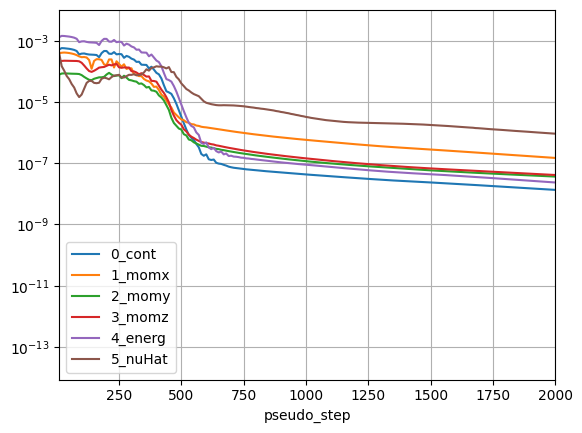

In [12]:
nonlinear_residuals_data = results.nonlinear_residuals.as_dataframe()
nonlinear_residuals_data.plot(
    "pseudo_step",
    ["0_cont", "1_momx", "2_momy", "3_momz", "4_energ", "5_nuHat"],
    logy=True,
    xlim=[10, 2000],
    grid=True,
)

To access the hinge torque history that was set with the `SurfaceIntegralOutput`, the `monitors` result type should be accessed.

Output()

[10:35:38] INFO: Saved to C:\Users\user\AppData\Local\Temp\tmprp_0gk5h\5874a8b1-0f4e-402b-99bd-327224fd4adb.csv

<Axes: xlabel='pseudo_step'>

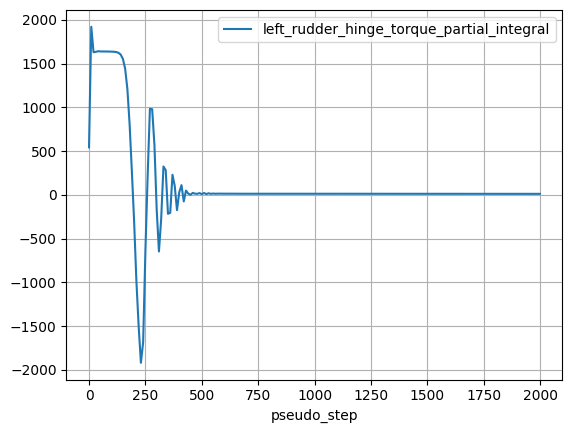

In [13]:
left_rudder_hinge_torque_history = results.monitors[
    "left_rudder_hinge_torque"
].as_dataframe()
left_rudder_hinge_torque_history.plot(
    "pseudo_step", "left_rudder_hinge_torque_partial_integral", grid=True
)

## 7. Report generation
This section illustrates the process for generating summary reports of simulation results with Flow360's reporting tool. Automated reports simplify compiling, visualizing, and sharing key simulation outputs, including tables, charts, and calculated quantities, without the need for manual post-processing. The example below builds and customizes a report that includes convergence history, force coefficients, and hinge torque summaries.

The object necessary to construct a `ReportTemplate` are imported from `flow360.plugins.report` namespace.

In [14]:
from flow360.plugins.report import (
    ReportTemplate,
    Chart2D,
    Table,
    NonlinearResiduals,
    DataItem,
    Average,
)

As the first entries to the report summary tables are created containing force coefficients of the whole aircraft and monitored hinge torques. 
An object representing data is the `DataItem` that is defined using the `data` argument which is a "path" to a certain variable as would be accessed through the `Case` object. 
For example to access angle of attack:
- through `Case`: `case.params.operating_condition.alpha`,
- path for `DataItem`: `"params/operating_condition/alpha"`.

`DataItem` also allows to perform operations on the base data provided. In this case an `Average` operation is performed to get the variables averaged over the last 10% of pseudo steps.  

In the cell below necessary `DataItem`s are defined and `Table`s are constructed. 

In [15]:
left_aileron_hinge_torque_final = DataItem(
    data="results/monitors/left_aileron_hinge_torque/left_aileron_hinge_torque_partial_integral",
    operations=[Average(fraction=0.1)],
)
right_aileron_hinge_torque_final = DataItem(
    data="results/monitors/right_aileron_hinge_torque/right_aileron_hinge_torque_partial_integral",
    operations=[Average(fraction=0.1)],
)
left_rudder_hinge_torque_final = DataItem(
    data="results/monitors/left_rudder_hinge_torque/left_rudder_hinge_torque_partial_integral",
    operations=[Average(fraction=0.1)],
)
right_rudder_hinge_torque_final = DataItem(
    data="results/monitors/right_rudder_hinge_torque/right_rudder_hinge_torque_partial_integral",
    operations=[Average(fraction=0.1)],
)

CL = DataItem(data="results/total_forces/CL", operations=[Average(fraction=0.1)])
CD = DataItem(data="results/total_forces/CD", operations=[Average(fraction=0.1)])

forces_table = Table(data=[CL, CD], section_title="Forces")
aileron_torques_table = Table(
    data=[
        left_aileron_hinge_torque_final,
        right_aileron_hinge_torque_final,
    ],
    section_title="Aileron hinge torques",
)
rudder_torques_table = Table(
    data=[left_rudder_hinge_torque_final, right_rudder_hinge_torque_final],
    section_title="Rudder hinge torques",
)

Another useful object to be used is `Chart2D` that allows to visualize time histories or pseudo step progressions of variables through the simulations. 
A different set of `DataItem`s has to be defined not to include the `Average` operation.

In [16]:
left_aileron_hinge_torque = DataItem(
    data="results/monitors/left_aileron_hinge_torque/left_aileron_hinge_torque_partial_integral",
    title="left_aileron_hinge_torque_monitor",
)
right_aileron_hinge_torque = DataItem(
    data="results/monitors/right_aileron_hinge_torque/right_aileron_hinge_torque_partial_integral",
    title="right_aileron_hinge_torque_monitor",
)
left_rudder_hinge_torque = DataItem(
    data="results/monitors/left_rudder_hinge_torque/left_rudder_hinge_torque_partial_integral",
    title="left_rudder_hinge_torque_monitor",
)
right_rudder_hinge_torque = DataItem(
    data="results/monitors/right_rudder_hinge_torque/right_rudder_hinge_torque_partial_integral",
    title="right_rudder_hinge_torque_monitor",
)

aileron_hinge_torques_convergence = Chart2D(
    x="results/monitors/left_aileron_hinge_torque/pseudo_step",
    y=[
        left_aileron_hinge_torque,
        right_aileron_hinge_torque,
    ],
    section_title="Aileron hinge torques convergence",
    show_grid=True,
    ylim=[-100, 100],
)

rudder_hinge_torques_convergence = Chart2D(
    x="results/monitors/left_rudder_hinge_torque/pseudo_step",
    y=[left_rudder_hinge_torque, right_rudder_hinge_torque],
    section_title="Rudder hinge torques convergence",
    show_grid=True,
    ylim=[-30, 30],
)

Finally all of the objects are compiled into one `ReportTemplate` and submitted to the cloud. An additional `NonlinearResiduals` object is added that automatically adds the plots of convergence to the report.

When submitting the report using `create_in_cloud` the list of `cases` has to be given. In this example only one is specified but when performing multiple simulations more cases can be specified and compared. The tables would then be populated with the data from all of the specified cases.

For an example of utilizing the report API for more `Case` instances see [Alpha sweep tutorial](./alpha_sweep.ipynb)  or [Wall roughness tutorial](./wall_roughness.ipynb)

In [17]:
template = ReportTemplate(
    title="Hinge forces report",
    items=[
        forces_table,
        aileron_torques_table,
        rudder_torques_table,
        NonlinearResiduals(),
        aileron_hinge_torques_convergence,
        rudder_hinge_torques_convergence,
    ],
)

report = template.create_in_cloud(name="hinge_forces", cases=[case])

report.wait()
report.download("report.pdf")

Output()

Output()

[10:36:58] INFO: Saved to report.pdf

'report.pdf'